# Machine Learning with scikit-learn

Sometimes the features you have available in your initial data have little predictive strength when used in the most straightforward way.  This might be true almost regardless of choice of model class and hyperparameters.  And yet it might also be true that there are synthetic features latent in the data that are highly predictive, but that have to be *engineered* (mechanically, rather than sample-wise modification) to produce powerful features.

At the same time, a highly dimension model—whether of high dimension because of the initial data collection or because of creation of extra synthetic features—may lend itself less well to modeling techniques.  In these cases, it can be more computationally tractable, as well as more predictive, to work with a subset of all available features.

In [58]:
# Some libraries tend to be in flux for their dependency versions
import warnings
warnings.simplefilter("ignore")

# We utilize some mglearn demo functions
import src.mglearn as mglearn

### A synthetic example

Let us look at an artificial example where raw features of a dataset of absolutely no value, but it is possible to derive good predictions by creating syntheric features out of them.  Obviously, real world data will not be as neat as that, but it is useful to express the concept.

At first brush the loaded data seems fairly noisy without an obvious pattern.

In [34]:
import pandas as pd
linf = pd.read_csv('data/linear_failure.csv', index_col=0)
linf.head()

,feature_1,feature_2,TARGET
0,0.162275,-0.282523,-0.045846
1,-0.874404,-0.164955,0.144237
2,0.000540,0.751708,0.000406
3,0.721775,-0.246271,-0.177752
4,0.374113,0.283637,0.106112


In [35]:
# The features seem uncorrelated, and no univariate correlation with target
linf.corr()

,feature_1,feature_2,TARGET
feature_1,1.000000,-0.006995,0.033990
feature_2,-0.006995,1.000000,-0.031077
TARGET,0.033990,-0.031077,1.000000


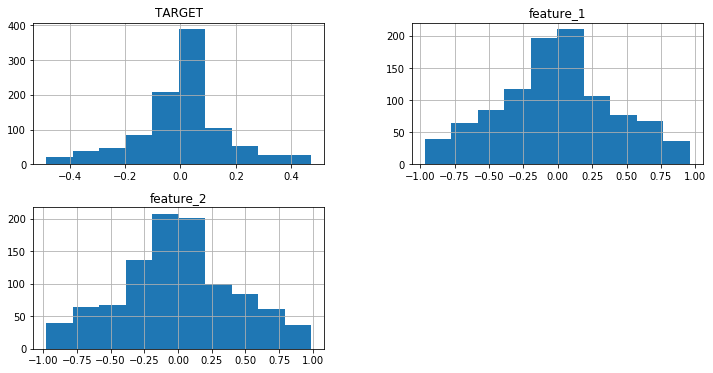

In [36]:
# Distribution of features and target looks roughly Gaussian
linf.hist(figsize=(12,6));

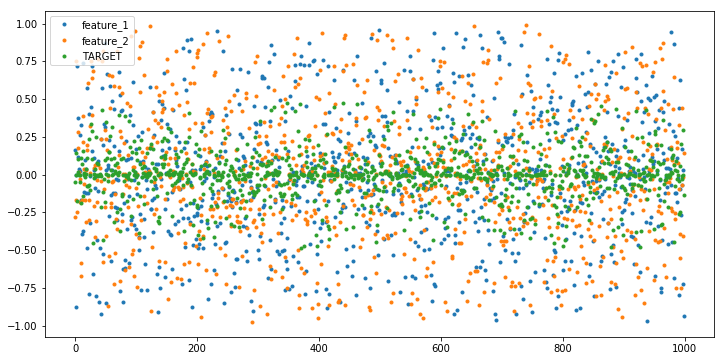

In [37]:
# No obvious trends in the data as sequences
%matplotlib inline
linf.plot(figsize=(12,6), style='.');

We might hope to identify a relationship between features and target using a linear regression such as this:

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = linf.drop('TARGET', axis=1)
y = linf['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

-0.0077727014623785165

Slightly different linear models do equally poorly in detecting any relationship between the features and the target.  Notice that the metric used here is $R^2$ score rather than e.g. explained variance or mean absolute error (or others).


In [39]:
from sklearn.linear_model import Lasso, Ridge
lasso, ridge = Lasso(), Ridge()
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

lasso.score(X_test, y_test), ridge.score(X_test, y_test)

(-0.0035696498877093585, -0.007721881351163473)

### Adding a feature

Let us try creating a new feature that is entirely based on existing features.

In [45]:
linf['f1xf2'] = linf.feature_1 * linf.feature_2
linf.head()

,feature_1,feature_2,TARGET,f1xf2
0,0.162275,-0.282523,-0.045846,-0.045846
1,-0.874404,-0.164955,0.144237,0.144237
2,0.000540,0.751708,0.000406,0.000406
3,0.721775,-0.246271,-0.177752,-0.177752
4,0.374113,0.283637,0.106112,0.106112


In [42]:
X = linf.drop('TARGET', axis=1)
y = linf['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

1.0

The information we need was "latent" in the data the whole time, it just needed to be teased out.

In fairness, we can note that other regressors manage to derive the synthetic feature through their algorithmic structure.  But these regressors will have their own "blind spots" also, relative to different datasets.

In [43]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.9997914313708574

In [44]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.9729453267239967

## Dimensionality reduction

There are two general approaches to *reducing* the number of dimensions (i.e. features) in a dataset.  One is by creating synthetic features that globally combine the raw features.  Several different mathematical techniques are available for doing this.

The other means by which we might reduce dimensions is simply by discarding ones that seem to have little significance to the model.  Very often models actually perform *better* by removing features that are either purely independent of the target or are largely redundant with other features (i.e. highly correlated).  In every case, models can be trained *faster* with fewer dimensions.

PCA is the oldest and most widely used method for decomposition of dimensional information.  Other methods of decomposition are also provided by scikit-learn.  In broad concept they do something similar, but each shows strengths relative to different datasets; understanding the difference is a mixture of domain familiarity and trial-and-error.

### Miscellaneous decompositions

This lesson will not specifically discuss all of the decomposition classes available in `sklearn.decomposition`.  A complete list with brief descriptions from the [documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) is below.  The discussion and examples of reconstructed faces in the [user guide](http://scikit-learn.org/stable/modules/decomposition.html) is very useful.

| Class name          | Description
|---------------------|------------------------------------
| DictionaryLearning  | Dictionary learning
| FactorAnalysis      | Factor Analysis (FA)
| FastICA             | FastICA: a fast algorithm for Independent Component Analysis.
| IncrementalPCA      | Incremental principal components analysis (IPCA).
| KernelPCA           | Kernel Principal component analysis (KPCA)
| LatentDirichletAllocation | Latent Dirichlet Allocation with online variational Bayes algorithm
| MiniBatchDictionaryLearning | Mini-batch dictionary learning
| MiniBatchSparsePCA  | Mini-batch Sparse Principal Components Analysis
| NMF                 | Non-Negative Matrix Factorization (NMF)
| PCA                 | Principal component analysis (PCA)
| SparsePCA           | Sparse Principal Components Analysis (SparsePCA)
| SparseCoder         | Sparse coding
| TruncatedSVD        | Dimensionality reduction using truncated SVD (aka LSA).
| dict_learning       | Solves a dictionary learning matrix factorization problem.
| dict_learning_online| Solves a dictionary learning matrix factorization problem online.
| fastica             | Perform Fast Independent Component Analysis.
| sparse_encode       | Sparse coding


### Principal component analysis (PCA)

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The transformation is defined in such a way that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

Let us look at an example. We will choose the Wisconsin breast cancer dataset we worked with in a previous lesson.  Recall that it has 30 features measuring a variety of numeric medical diagnostic results.

First thing, we load the dataset and apply standard scaling to the features.  Later in this lesson we will talk more about scaling, and we have brushed on it in a few previous lessons.

In [53]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

Perform a standard train/test split as we have with almost all models.

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, cancer.target, random_state=1)

For pending comparison, let us remind ourselves of how the raw data preforms using two classifers: `LinearRegression` and `KNeighborsClassifier`.

In [61]:
from sklearn.linear_model import LinearRegression
(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.7222686011972144

In [62]:
from sklearn.neighbors import KNeighborsClassifier
(KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.951048951048951

Now we transform the parametric space of the features into just two dimensions that contain the maximum amount of information that **can be** represented in two dimensions.

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: %s" % str(X_scaled.shape))
print("Reduced shape: %s" % str(X_pca.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


Looking at a scatter plot, we can see that just two dimensions already get rather good differentiation visually.  Notice that these two components each represent an arbitrary combination of all the actual observational measurements in the dataset.  Therefore, they do not have any obvious English description other than "first component" and "second component."

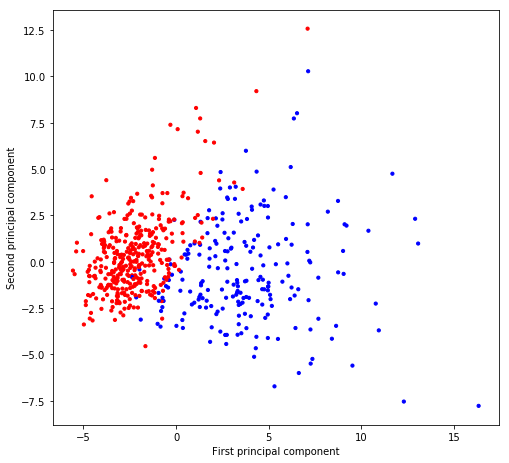

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

With just two components retained, the linear regression performs a bit worse, but KNN (that is much stronger so far for this data, in any case), performs basically equally well as with all 30 dimensions.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, cancer.target, random_state=1)

In [65]:
(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.6279864206554091

In [66]:
(KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test))

0.9440559440559441

We can see how the two PCA components are derived by linear combination of the original 30.

In [68]:
print(pca.components_)

[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


Or more visually (but only some original features shown for legibility):

<Figure size 1440x1080 with 0 Axes>

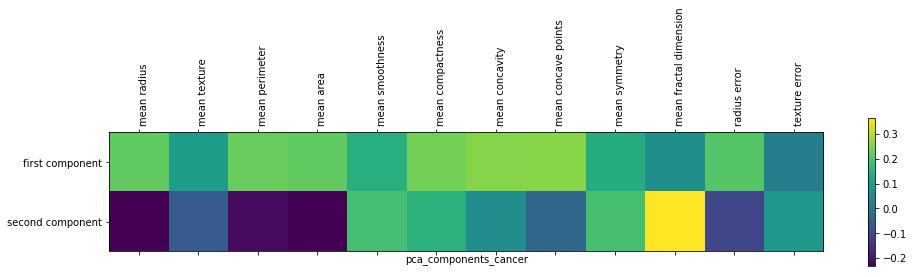

In [71]:
# Not all original features shown...
nfeat = 12
plt.figure(figsize=(20,15))
plt.matshow(pca.components_[:,:nfeat], cmap='viridis')
plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(nfeat),
           cancer.feature_names[:nfeat], rotation=90, ha='left');
plt.xlabel("pca_components_cancer");

### Rotation, sphering and whitening

This course will not have time to address it, but additional preprocessing steps such as subtracting off the mean or calculating a z-score `(X-X.mean())/X.std()` can improve the fit of a PCA model.  The `PCA` class has options for some of these operations built in.

### Non-negative matrix factorization (NMF)

NMF finds two non-negative matrices whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [73]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
nmf.fit(cancer.data)
X_nmf = pca.transform(cancer.data)
print("Original shape: %s" % str(cancer.data.shape))
print("Reduced shape: %s" % str(X_pca.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


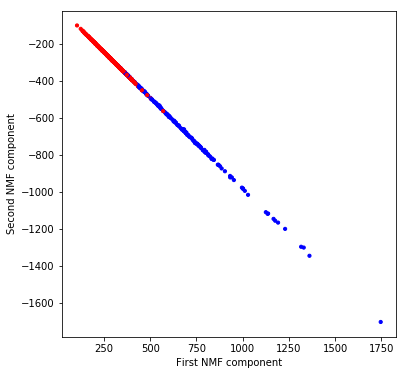

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(6, 6))
plt.scatter(X_nmf[:, 0], X_nmf[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First NMF component")
plt.ylabel("Second NMF component");

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X_nmf, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.51335911567084
0.8531468531468531


### Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model for collections of discrete dataset such as text corpora. It is also a topic model that is used for discovering abstract topics from a collection of documents.

This Bayesian technique has proven very useful for identifing hidden unobserved features in textual data sources.  It is not particularly well suited to the kind of numeric data we see in the cancer dataset, but we use that simply to show API usage here. Basically, it is the same as other decomposition classes—and generally the same as all the models throughout scikit-learn.

In [89]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=2)
lda.fit(cancer.data)
X_lda = lda.transform(cancer.data)
print("Original shape: %s" % str(cancer.data.shape))
print("Reduced shape: %s" % str(X_lda.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


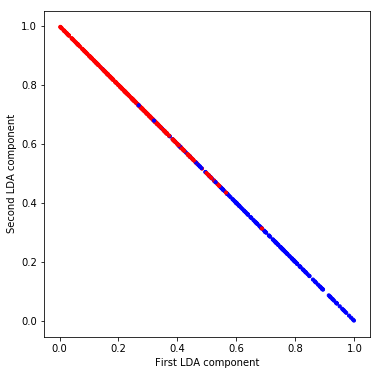

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(6, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First LDA component")
plt.ylabel("Second LDA component");

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lda, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.5741463988915751
0.9090909090909091


### Independent component analysis (ICA)

Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is implemented in scikit-learn using the Fast ICA algorithm. Typically, ICA is not used for reducing dimensionality but for separating superimposed signals. 

> In PCA the basis you want to find is the one that best explains the variability of your data. The first vector of the PCA basis is the one that best explains the variability of your data (the principal direction) the second vector is the 2nd best explanation and must be orthogonal to the first one.

> In ICA the basis you want to find is the one in which each vector is an independent component of your data, you can think of your data as a mix of signals and then the ICA basis will have a vector for each independent signal.

> In a more practical way we can say that PCA helps when you want to find a reduced-rank representation of your data and ICA helps when you want to find a representation of your data as independent sub-elements. In layman terms PCA helps to compress data and ICA helps to separate data.

Quote credit: [Luis Argerich](https://www.quora.com/What-is-the-difference-between-PCA-and-ICA), Data Science Professor at the University of Buenos Aires (UBA)

In [95]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
ica.fit(cancer.data)
X_ica = ica.transform(cancer.data)
print("Original shape: %s" % str(cancer.data.shape))
print("Reduced shape: %s" % str(X_ica.shape))

Original shape: (569, 30)
Reduced shape: (569, 2)


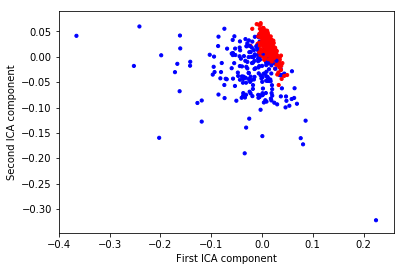

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot 1st vs 2nd principal component, color by class
plt.figure(figsize=(6, 6))
plt.scatter(X_ica[:, 0], X_ica[:, 1], 
            c=cancer.target, 
            cmap=mglearn.tools.cm, s=10)
plt.gca().set_aspect("equal")
plt.xlabel("First ICA component")
plt.ylabel("Second ICA component");

One might hope that since ICA is often used for separation of "signals" in noisy data, the cancer data might do better than PCA at detecting the "benign" and "malignant" signals that might be reflected in the indirect medical measurements.

At least without other parameterization, or other models, and looking at exactly two components, ICA does moderately worse than PCA.  Only very slightly so though; it is possible that other feature engineering might allow ICA to emerge as a good technicque for this problem area. 

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ica, cancer.target, random_state=1)
print(LinearRegression()
    .fit(X_train, y_train)
    .score(X_test, y_test))
print((KNeighborsClassifier()
    .fit(X_train, y_train)
    .score(X_test, y_test)))

0.48826561832822657
0.9370629370629371


### t-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

That is to say, t-SNE can often help models in similar ways to what PCA, NMF, LDA, or ICA do.  But it also is especially useful to create low-dimensional representations (i.e. two dimensions can actually fit on your computer monitors or printed books).

An example that shows t-SNE well is the digit dataset that we saw in an earlier lesson.  Let us load that data, and decompose it with both PCA and t-SNE.

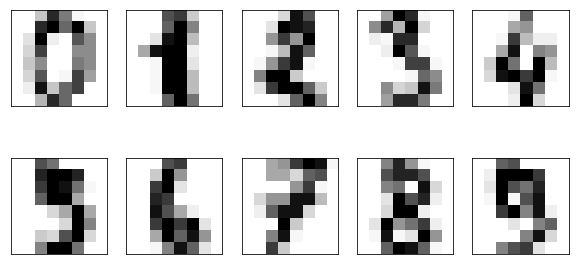

In [79]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img, cmap=plt.get_cmap('Greys'))

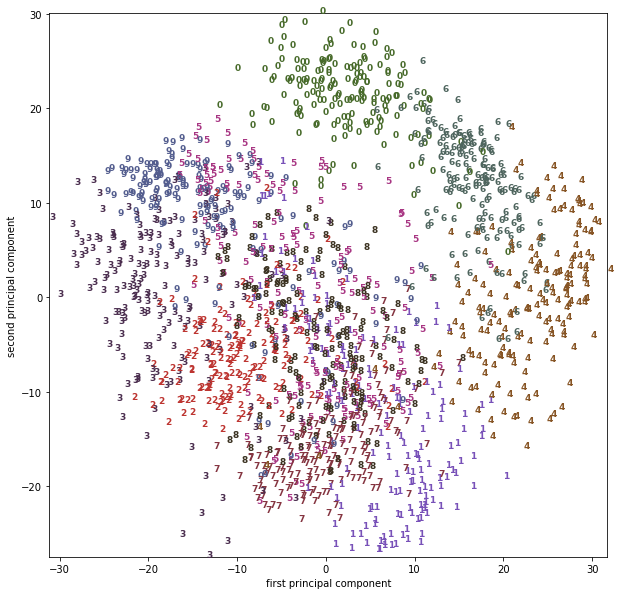

In [80]:
# build a PCA model
pca = PCA(n_components=2)
pca.fit(digits.data)

# transform the digits data onto the first two principal components
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120","#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("first principal component")
plt.ylabel("second principal component");

In [81]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method:
digits_tsne = tsne.fit_transform(digits.data)

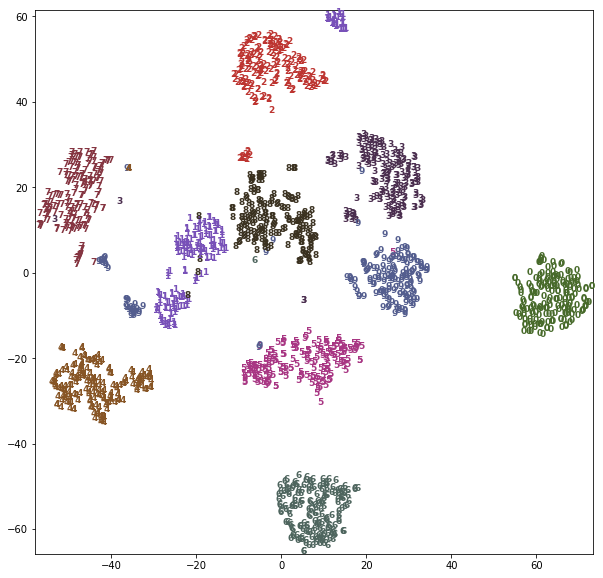

In [82]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

### SelectKBest

## Dimensionality expansion

### Polynomial Features

### One-Hot Encoding

## Scaling 

### StandardScaler

### RobustScaler

### MinMaxScaler

### Normalizer

### ...and others

## Binning values with quantiles or binarize